In [115]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# testing file
file = xr.open_dataset('/Users/victoriaford/Downloads/CWOP_AT291.nc')
df = file.to_dataframe()
df = df.reset_index() # in order to grab the time information more easily -- would prefer not to do this
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df

,station,time,tas,hurs,sfcWind,sfcWind_dir,ps_altimeter,tas_qc,sfcWind_qc,sfcWind_dir_qc,pr_5min,pr_5min_qc,pr_24h,tdps_derived,ps_derived,elevation,lat,lon,month
0,CWOP_AT291,2009-09-23 20:03:00,288.16,35.0,4.02,16.0,79459.12,nan,nan,nan,NaN,nan,0.0,272.72,61453.03,2114.0928,41.37083,-106.71667,9
1,CWOP_AT291,2009-09-23 20:18:00,287.61,33.0,4.91,19.0,79435.55,nan,nan,nan,NaN,nan,0.0,271.43,61434.80,2114.0928,41.37083,-106.71667,9
2,CWOP_AT291,2009-09-23 20:33:00,288.16,33.0,4.91,24.0,79427.70,nan,nan,nan,NaN,nan,0.0,271.92,61428.73,2114.0928,41.37083,-106.71667,9
3,CWOP_AT291,2009-09-23 20:48:00,287.61,36.0,5.36,338.0,79411.98,nan,nan,nan,NaN,nan,0.0,272.62,61416.57,2114.0928,41.37083,-106.71667,9
4,CWOP_AT291,2009-09-23 21:03:00,287.05,38.0,3.13,299.0,79411.98,nan,nan,nan,NaN,nan,0.0,272.87,61416.57,2114.0928,41.37083,-106.71667,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84591,CWOP_AT291,2013-07-29 19:13:00,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,NaN,nan,0.0,NaN,NaN,2114.0928,41.37083,-106.71667,7
84592,CWOP_AT291,2013-07-29 19:18:00,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,NaN,nan,0.0,NaN,NaN,2114.0928,41.37083,-106.71667,7
84593,CWOP_AT291,2013-07-29 19:23:00,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,NaN,nan,0.0,NaN,NaN,2114.0928,41.37083,-106.71667,7
84594,CWOP_AT291,2013-07-29 19:28:00,NaN,NaN,NaN,NaN,NaN,nan,nan,nan,NaN,nan,0.0,NaN,NaN,2114.0928,41.37083,-106.71667,7


In [ ]:
## part 1
## compare anomalies of monthly median values

# standardize against interquartile range, and compare stepwise from the middle of the distribution outwards
# asymmetries are identified and flagged if severe

# this would flag at the monthly level -- is this even useful for us? would flag bad months as a whole
# could use to analyze that month in particular?

# scratch code below
# ---------------------------------------------------------------------
df2 = df[['time', 'tas', 'month']]

# climatology monthly median values
df_med_clim = df2.groupby(df['time'].dt.month).median(numeric_only=True)
df_med_clim = df_med_clim.rename(columns={'tas': 'tas_clim'})

# each individaul month median values
df_med_all = df2.resample('M', on='time').median(numeric_only=True)

df_test2 = df_med_all.merge(df_med_clim.reset_index()[['month', var+'_clim']])

df_test2['anom'] = df_test2['tas'] - df_test2['tas_clim']

# all monthly medians are converted to anomalies from calendar monthly median
test_df = df_med_all.merge(df_med_clim.reset_index(), on='month', how='left')

test_df['anom'] = test_df['tas_x'] - test_df['tas_y']
test_df

In [ ]:
## part2 

# compare all observations in a single month, all years
# histogram created from all obs and gaussian distribution is fitted
# threshold values are determined using positions where fitted frequency falls below y=0.1
# and rounding outwards to the next integer plus one
# going outwards from center, distribution is scanned for gaps which occur outside threshold value
# obs beyond gap are flagged


## gaussian distribution may not be a perfect fit for bulk of obs, with thresholds too high
## allow for non-zero skew and kurtosis by using gauss-hermite series
## updated thresholds occur closer to bulk of distribution curve

#--------------------------------------------------------------------------------------
# intention is to have a function like: 

# def qaqc_dist_gaps_check(df, plot=False):
#     if plot=True:
#         plot_gap_check(df, var) # etc. 

In [52]:
# identify the actual data vars
vars_to_remove = ['duration', 'method', 'lat', 'lon', 'elevation', 'qc', 'station', 'time', 'month']
[d for d in df.columns if not any(True for item in vars_to_remove if item in d)]

['tas',
 'hurs',
 'sfcWind',
 'sfcWind_dir',
 'pr_5min',
 'pr_24h',
 'tdps_derived',
 'ps_derived']

In [222]:
def plot_gap_check(df, var):
    # plot histogram with count values against the standardized IQR
    num_bins = int(df[var].max()) + 1 - int(df[var].min())
    N = 10000 # what is this number - it matters!
    
    # standardize against IQR range
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    df_month_iqr = (df[var].values - df[var].median()) / iqr
    
    x = df_month_iqr
    plt.hist(x, bins=num_bins, alpha=0.3);
    xmin, xmax = plt.xlim()
    
    kur = stats.kurtosis(x, fisher=True)
    sk = stats.skew(x)

    # plot pdf
    if var == 'tas' or var == 'tdps' or var =='tdps_derived':
#         plt.xlim([-5,5])
        y = np.linspace(-5, 5, num_bins)
    else:
        y = np.linspace(xmin, xmax, num_bins)
    bin_width = (x.max() - x.min()) / num_bins
    plt.plot(y, stats.norm.pdf(y) * N * bin_width, color='k', lw=1)

    # add vertical lines to indicate thresholds -- clearly not correct
    pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y)))
    plt.axvline(x=y[stats.norm.pdf(y).tolist().index(pdf_idx[0])], color='r') # left tail
    plt.axvline(y[stats.norm.pdf(y).tolist().index(pdf_idx[-1])], color='r') # right tail
    
    plt.gca().set_yscale('log')

    # flag (visually) obs that are beyond threshold
    # bar_value_to_label = -2.25
    # patch_index = np.digitize([bar_value_to_label], x)[0]
    # hh.patches[patch_index].set_color('r')
    # hh.patches[patch_index].set_alpha(1)

    # title and useful annotations
    plt.title('QA/QC Distributional gap for {0}: {1}'.format(df_month['station'].unique()[0], var));
    plt.annotate('Month: {}'.format(m), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10);
    plt.annotate('Mean: {}'.format(round(np.nanmean(df_month_iqr),3)), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(np.nanstd(df_month_iqr),3)), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=8);
    plt.annotate('Skew: {}'.format(round(sk,3)), xy=(0.05,0.8), xycoords='axes fraction', fontsize=8)
    plt.annotate('Kurtosis: {}'.format(round(kur,3)), xy=(0.05, 0.75), xycoords='axes fraction', fontsize=8)
    plt.ylabel('Frequency (obs)')
    plt.xlabel('{} offset (IQR)'.format(var));
    
    # put AWS save figure stuffs here
    
    return

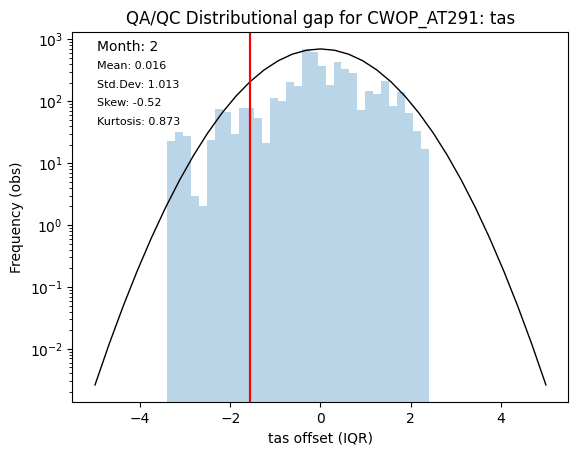

In [223]:
m = 2
df_month = df.loc[df['month'] == m]

plot_gap_check(df_month, var='tas')

In [218]:
# identifying where pdf curve is below 0.1 threshold

pdf_idx = list(filter(lambda i: i > 0.1, stats.norm.pdf(y).tolist()))
pdf_idx

[0.12798083034746327,
 0.16055520814546523,
 0.19640914652400143,
 0.23429167388785602,
 0.2725271898818575,
 0.3091154108190664,
 0.34189229416612926,
 0.3687362238829399,
 0.3877931483198097,
 0.39768782486036985,
 0.3976878248603699,
 0.3877931483198097,
 0.3687362238829401,
 0.34189229416612926,
 0.30911541081906657,
 0.2725271898818577,
 0.23429167388785616,
 0.19640914652400165,
 0.16055520814546534,
 0.12798083034746327]

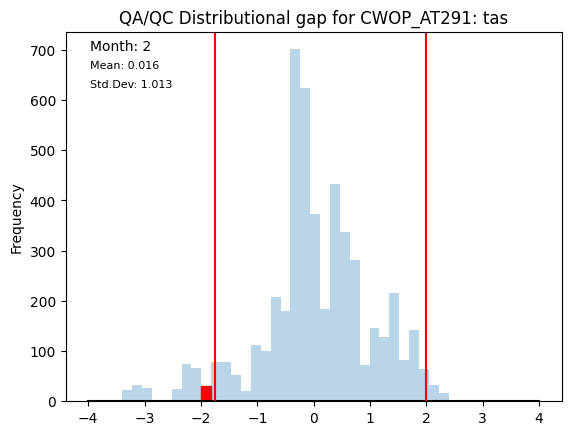

In [152]:
# scratch working place -- would like to be able to "flag" obs with a different color if possible
# example below

num_bins = int(df_month[var].max()) + 1 - int(df_month[var].min())
mu, std = norm.fit(df_month[var].dropna())
s = pd.Series(df_month_iqr)
hh = s.plot(kind='hist', bins=num_bins, density=False, alpha=0.3)
xmin, xmax = plt.xlim()

# plot PDF
if var == 'tas' or var == 'tdps' or var =='tdps_derived':
    x = np.linspace(-4, 4, num_bins)
else:
    x = np.linspace(xmin, xmax, num_bins)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k')

# add vertical lines to indicate thresholds
plt.axvline(x=-1.75, color='r') # left tail
plt.axvline(x=2.0, color='r') # right tail

# flag (visually) obs that are beyond threshold
bar_value_to_label = -2.25
patch_index = np.digitize([bar_value_to_label], x)[0]
hh.patches[patch_index].set_color('r')
hh.patches[patch_index].set_alpha(1)

# title and useful annotations
plt.title('QA/QC Distributional gap for {0}: {1}'.format(df_month['station'].unique()[0], var));
plt.annotate('Month: {}'.format(m), xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10);
plt.annotate('Mean: {}'.format(round(np.nanmean(df_month_iqr),3)), xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8);
plt.annotate('Std.Dev: {}'.format(round(np.nanstd(df_month_iqr),3)), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=8);